# Diabetes Prediction Portfolio Project(imbalanced)

## 1. Project Overview
This project aims to predict diabetes using the `diabetes_binary_health_indicators_BRFSS2015.csv` dataset from Kaggle. It explores EDA, feature engineering, resampling with SMOTE, model building, and interpretation using XGBoost.

---

## 2. Dataset Summary
- Source: [Kaggle - BRFSS2015](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset)
- Records: 253680
- Target: `Diabetes_binary` (1 = has diabetes, 0 = no diabetes)

---





## 3. Initial Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look nice
sns.set(style="whitegrid")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving diabetes_binary_health_indicators_BRFSS2015.csv to diabetes_binary_health_indicators_BRFSS2015.csv


In [ ]:
df = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")
# View shape and first few rows
print("Shape:", df.shape)
df.head()

Shape: (253680, 22)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [ ]:
# Dataset overview
df.info()

# Check for missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

,0
Diabetes_binary,0
HighBP,0
HighChol,0
CholCheck,0
BMI,0
Smoker,0
Stroke,0
HeartDiseaseorAttack,0
PhysActivity,0
Fruits,0




---




## 4. Exploratory Data Analysis (EDA)
### Target Variable Distribution

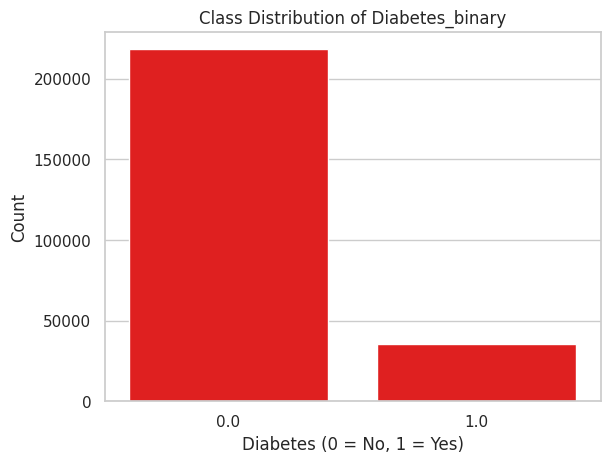

,proportion
Diabetes_binary,
0.0,86.066698
1.0,13.933302


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Class distribution plot
sns.countplot(x="Diabetes_binary", data=df, color='red')
plt.title("Class Distribution of Diabetes_binary")
plt.xlabel("Diabetes (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Percentage distribution
df["Diabetes_binary"].value_counts(normalize=True) * 100

Class Imbalance: ~14% diabetic, ~86% non-diabetic

**Correlation with Target**

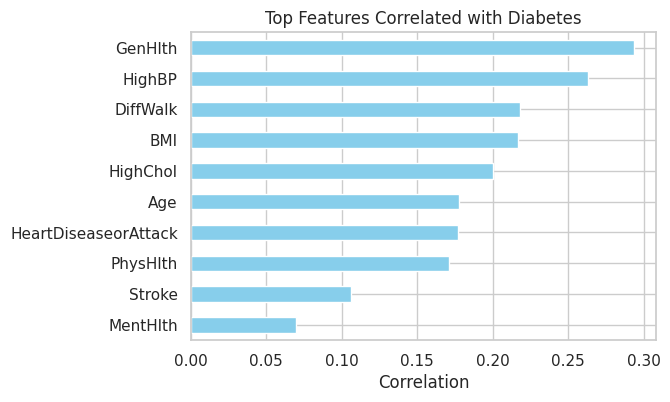

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation with target
correlation = df.corr(numeric_only=True)["Diabetes_binary"].sort_values(ascending=False)

# Plot top correlations
plt.figure(figsize=(6,4))
correlation[1:11].plot(kind="barh", color="skyblue")  # Skip self-correlation
plt.title("Top Features Correlated with Diabetes")
plt.xlabel("Correlation")
plt.gca().invert_yaxis()
plt.show()



---



## 5. Feature Engineering



**🔹 1. Remove Low-Variance Features**

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Drop target column temporarily
X_temp = df.drop('Diabetes_binary', axis=1)

# Apply Variance Threshold
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X_temp)

# Retain selected features
retained_cols = X_temp.columns[selector.get_support()]
df = df[retained_cols.tolist() + ['Diabetes_binary']]

🔹 **2. Create Interaction Features**

In [ ]:
# Example: Interaction between HighBP and BMI
df['HighBP_BMI'] = df['HighBP'] * df['BMI']


**🔹3. Bin Continuous Features**

In [ ]:
df['BMI_Bin'] = pd.cut(df['BMI'],
                       bins=[0, 18.5, 25, 30, 40, 100],
                       labels=['Underweight', 'Normal', 'Overweight', 'Obese', 'Severely Obese'])

# Convert to string to prevent issues with get_dummies
df['BMI_Bin'] = df['BMI_Bin'].astype(str)

🔹 **4. Encode Binned / Categorical Features**

In [ ]:
df = pd.get_dummies(df, columns=['BMI_Bin'], drop_first=True)

🔹**5. Scale Continuous Features**

In [ ]:
from sklearn.preprocessing import StandardScaler

# Features to scale (modify based on actual column names retained)
scale_cols = ['BMI', 'MentHlth', 'PhysHlth', 'Age']

scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])



---



## 6. Handling Imbalance with SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
# Apply SMOTE only to training data
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Confirm new class distribution
import numpy as np
unique, counts = np.unique(y_train_resampled, return_counts=True)
print(dict(zip(unique, counts)))

{np.float64(0.0): np.int64(174667), np.float64(1.0): np.int64(174667)}




---



## 7. Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# X = features, y = target
X = df.drop("Diabetes_binary", axis=1)
y = df["Diabetes_binary"]

# Train-test split before SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



---



## 8. Modeling


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

🔹 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_smote, y_train_smote)

log_preds = log_model.predict(X_test)
log_probs = log_model.predict_proba(X_test)[:, 1]

log_acc = accuracy_score(y_test, log_preds)
log_auc = roc_auc_score(y_test, log_probs)

print("Logistic Regression - Accuracy:", round(log_acc, 3))
print("Logistic Regression - AUC:", round(log_auc, 3))

Logistic Regression - Accuracy: 0.733
Logistic Regression - AUC: 0.819


🔹 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

rf_acc = accuracy_score(y_test, rf_preds)
rf_auc = roc_auc_score(y_test, rf_probs)

print("Random Forest - Accuracy:", round(rf_acc, 3))
print("Random Forest - AUC:", round(rf_auc, 3))

Random Forest - Accuracy: 0.851
Random Forest - AUC: 0.793


🔹 XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)

xgb_preds = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

xgb_acc = accuracy_score(y_test, xgb_preds)
xgb_auc = roc_auc_score(y_test, xgb_probs)

print("XGBoost - Accuracy:", round(xgb_acc, 3))
print("XGBoost - AUC:", round(xgb_auc, 3))

XGBoost - Accuracy: 0.863
XGBoost - AUC: 0.822




---



## 9. Model Comparison

In [ ]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [0.733, 0.851, 0.863],
    'AUC': [0.819, 0.793, 0.822]
})
print(results)

                 Model  Accuracy    AUC
0  Logistic Regression     0.733  0.819
1        Random Forest     0.851  0.793
2              XGBoost     0.863  0.822




---



## 10. Feature Importance (XGBoost)

Text(0.5, 0, 'Importance Score')

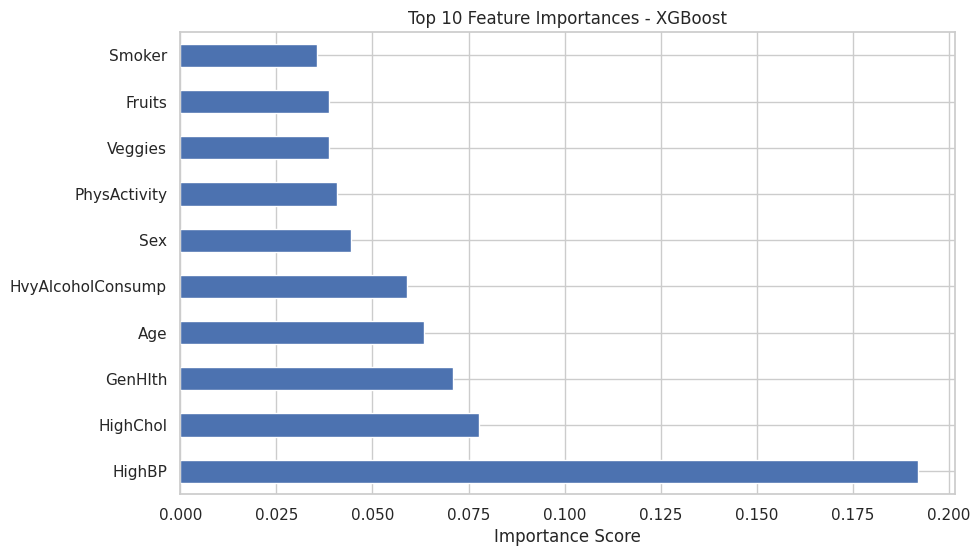

In [ ]:
import matplotlib.pyplot as plt
importances = xgb_model.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
feat_importance[:10].plot(kind='barh', figsize=(10,6))
plt.title("Top 10 Feature Importances - XGBoost")
plt.xlabel("Importance Score")

### Interpretation:
- **Top predictors:** HighBP, HighChol, GenHlth, Age, HvyAlcoholConsump
- **HighBP** is the strongest indicator of diabetes in this model


---



## 11. Conclusion
- XGBoost performed best with 86.3% accuracy and 82.2% AUC.
- SMOTE successfully addressed class imbalance.
- Key drivers: **Blood Pressure**, **Cholesterol**, **General Health**, and **Age**.

---

## 12. Next Steps
- Try alternative resampling techniques (Tomek Links, ADASYN)
- Tune XGBoost hyperparameters
- Save and deploy model (e.g., Flask, Streamlit)



---

